# Noise Power Spectra

In [17]:
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
from astropy.cosmology import Planck15 as cosmo
from twentyonecmFAST import load_binary_data
from powerbox.powerbox import get_power
from astropy import constants as const
import sys

## 21cm Noise Auto Spectrum

$$\sigma_{21}^2 = \left[ P_{21}\left(k, \mu \right) + \frac{T^2_{\rm sys} V_{\rm sur}}{B \ t_{\rm int} \ n \left(k_{\perp}\right)} {\rm W}_{21}\left(k, \mu \right) \right]$$

$$ {\rm W}_{21}\left(k, \mu \right) = e^{\left(k_{\parallel} / k_{\parallel, \rm res} \right)^2 + \left(k_{\perp} / k_{\perp, \rm res} \right)^2}$$

The parallel modes and perpendicular modes can be determine with $k_{\parallel} = \mu k$ and $k_{\perp} = \left( 1 - \mu^2 \right)^{1/2} k$

$$k_{\parallel, \rm res} = \frac{R_{\rm res} H \left( z\right)}{c \left(1 + z\right)} = \frac{1}{\Delta x_{\parallel, \rm res}}$$

Ra $R_{\rm res} = \nu_{21} \left( z \right) / \nu_{\rm res}$

$$k_{\perp, \rm res} = \frac{1}{\chi \left( z \right) \theta_{\rm min}} = \frac{1}{\Delta x_{\perp, \rm res}}$$

Here's some text

$$\theta_{\rm min} = \left( x_{\rm pix} / 60 \right) \left(\pi / 180 \right)$$

Here's some text

$$x_{\rm pix} = \lambda_{21} \left( z \right) / l_{\rm max}$$

Reasonable estimates for HERA: $T_{\rm sys} \approx 200 \ {\rm K}$, $B = 8 \ {\rm MHz}$, $t_{\rm int} = 1000 \ {\rm hr}$

In [2]:
c = 3e8 * u.m / u.second

In [3]:
def variance_21cm(P, z):
    return (P ** 2 + W)

def W_21(z):
    return np.exp((k_par / k_par_res(z).value) ** 2 + (k_perp / k_perp_res(z).value) ** 2)

def k_perp(k, mu):
    return k * mu

def k_par(k, mu):
    return (1 - mu**2)**(1.0/2.0) * k


"""
Parallel Mode Resolution
"""

def k_par_res(z):
    return 2 * np.pi * (R_res(z) * cosmo.H(z) / (c * (1 + z))).to(u.Mpc ** -1)

def R_res(z, nu_res = 3.9e3):
    """
    """
    return ((1420 * u.MHz) / ((1 + z) * (nu_res * u.Hz))).to(u.dimensionless_unscaled)


"""
Perpendicular Mode Resolution
"""

def k_perp_res(z):
    return 2 * np.pi / (cosmo.comoving_distance(z) * theta_min(z))

def theta_min(z):
    '''
    Theta
    '''
    def x_pix(z, l_max = 1e5):
        '''
        Parameters:
            z: (float)
                redshift
            l_max: (float)
                Maximum baseline length

        Returns 
        '''
        l_21 = 21 * u.cm
        return (l_21 * (z + 1) / (l_max * u.cm)) * (np.pi / 180) / 60.
    
    return x_pix(z)

In [4]:
def N_m(z):
    return V_sur(z) * d_k * d_mu * k ** 2 / (4 * np.pi)

def A_eff(D, ants = 350):
    return ants * np.pi * (D ** 2.0) / 4

def V_sur(z):
    l_21 = (21.1 * u.cm) * (1 + z)
    return cosmo.comoving_distance(z) ** 2 * survey_depth * (l_21 ** 2.0 / A_eff(z)) ** 2.0

def wedge(z, k_perp, theta_0 = np.pi / 2.0):
    return (cosmo.comoving_distance(z) * cosmo.efunc(z) * theta_0 * k_perp / 
            (cosmo.hubble_distance * (1 + z)))

In [5]:
k_perp = np.linspace(0, 4, 100)

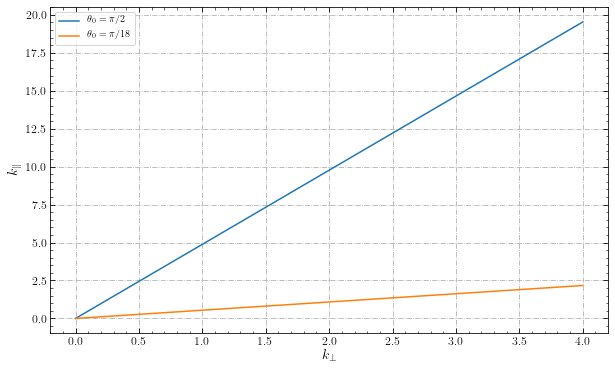

In [6]:
plt.figure(figsize=(10,6))
plt.plot(k_perp, wedge(7, k_perp), label = r'$\theta_0 = \pi / 2$')
plt.plot(k_perp, wedge(7, k_perp, np.pi / 18.0), label = r'$\theta_0 = \pi / 18$')
plt.xlabel(r'$k_{\perp}$')
plt.ylabel(r'$k_{\parallel}$')
plt.grid()
plt.legend()
plt.show()

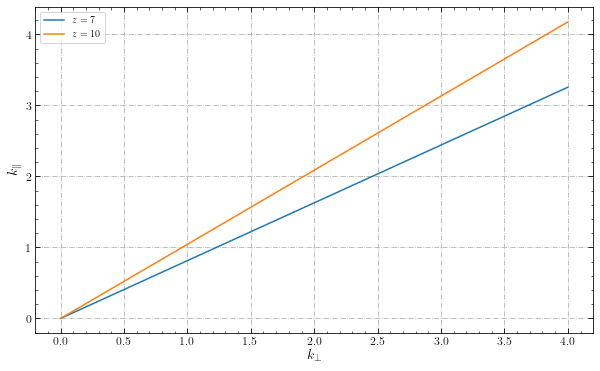

In [7]:
plt.figure(figsize=(10,6))
plt.plot(k_perp, wedge(7, k_perp, np.deg2rad(15)), label = r'$z = 7$')
plt.plot(k_perp, wedge(10, k_perp, np.deg2rad(15)), label = r'$z = 10$')
plt.xlabel(r'$k_{\perp}$')
plt.ylabel(r'$k_{\parallel}$')
plt.grid()
plt.legend()
plt.show()

## Ly$\alpha$ Noise Auto Spectrum

## 21cm-Ly$\alpha$ Cross-Power Spectrum Variance

$$\sigma_{21,{\rm Ly}\alpha}^2 \left(k, \mu \right) = \frac{1}{2}\left[ P_{21,{\rm Ly}\alpha}^2 \left(k, \mu \right) + \sigma_{21} \left(k, \mu \right) \sigma_{\rm Ly \alpha} \left(k, \mu \right) \right]$$

In [77]:
def I_21(T, z):
    """
    Convert mean brightness temperature to a surface brightness
    """
    nu = 1420 * u.MHz / (z + 1)
    I = 2. * const.h * nu ** 3 / const.c ** 2 * 1.0 / (np.exp(const.h * nu / (const.k_B * T)) - 1)
    return (nu * I).to(u.erg / u.cm ** 2 / u.s)

In [78]:
f = '../../data/delta_T_v3_z007.04_nf0.233584_useTs1_256_200Mpc'
data_cube = load_binary_data(f)
dc = data_cube.reshape((256,256,256))

In [79]:
ps_21, k_21, var_21 = get_power(dc / dc.mean() - 1, 200, bins = 14, 
                               log_bins = True, dimensionless = True, 
                               get_variance=True)

delta = k_21 ** 3 * ps_21 / (2 * np.pi ** 2)
delta_dim = I_21(dc.mean() * u.mK, 7.04) ** 2 * delta

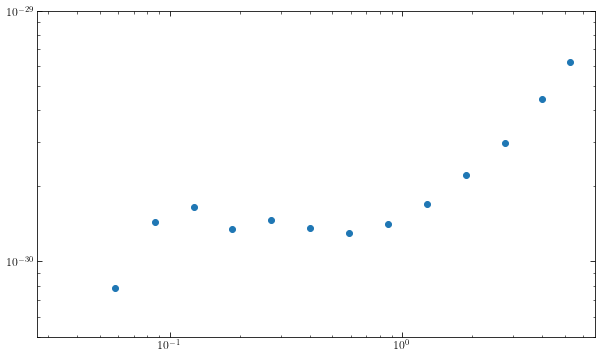

In [85]:
plt.figure(figsize=(10,6))
plt.scatter(k_21, delta_dim)
plt.plot(k_21, delta_dim, alpha = 0)
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-31, 1e-29])
plt.show()